In [1]:
import numpy as np 
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
from kernel_sca import *
from utils import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import wandb

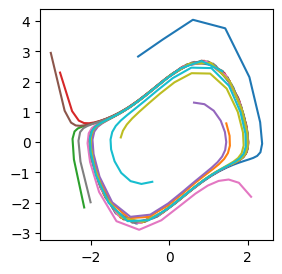

In [15]:
def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - x2 
    dx2_dt = x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]


t_span = (0, 10)                                    # simulate from t=0 to t=10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 50)     # time points where the solution is computed


num_trajectories = 10

seed = 42
np.random.seed(seed) 
initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(num_trajectories, 2))

plt.figure(figsize=(3,3))
for initial_conditions in initial_conditions_list:
    solution = solve_ivp(van_der_pol, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    plt.plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')

#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )
X = np.zeros((num_trajectories, 2, len(t_eval)))
for i, initial_conditions in enumerate(initial_conditions_list):
    solution = solve_ivp(van_der_pol, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]

    X[i, 0, :] = x1
    X[i, 1, :] = x2
X = jnp.array(X)


(10, 10, 50)


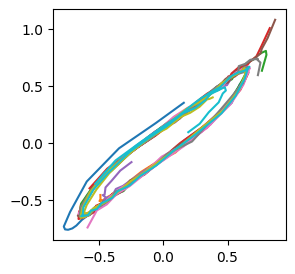

In [16]:
seed = 42
key = random.PRNGKey(seed)
key, subkey = random.split(key)

proj_dims = 10
proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)

X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
print(X.shape)

noise = random.normal(subkey, (X.shape)) 
X += (noise)  /100
X = jnp.array(X)
K, N, T = X.shape

plt.figure(figsize=(3,3))
for i,initial_conditions in enumerate(initial_conditions_list):
    plt.plot(X[i,0,:],X[i,10,:] )

A = jnp.swapaxes(pre_processing(X,center=True, pca=False, soft_normalize=False)[0], 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                                                                                        #(N, K*T)

K_A_X = K_X_Y_identity(A, X)                                     #(K*T, K, T)

K_A_A = K_X_Y_identity(A, A)
K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

In [17]:
d=2
wandb.init(project="SCA-project-toydata-kernel", name="run_1", mode="disabled")
alpha_tilde, ls_loss, ls_S_ratio = optimize(P, S, K_A_X, X, d=d, learning_rate=0.01, iterations=500) 
wandb.finish

Iteration 0, S: 0.0025522278156131506, S_ratio: 0.36807504296302795
Iteration 10, S: 0.006735413800925016, S_ratio: 0.44803985953330994
Iteration 20, S: 0.016476185992360115, S_ratio: 0.6565621495246887
Iteration 30, S: 0.04548453167080879, S_ratio: 0.48171520233154297
Iteration 40, S: 0.12546250224113464, S_ratio: 0.7446621656417847
Iteration 50, S: 0.3740304708480835, S_ratio: 0.7610251903533936
Iteration 60, S: 1.1529505252838135, S_ratio: 0.8529598712921143
Iteration 70, S: 3.5543785095214844, S_ratio: 0.5774856805801392
Iteration 80, S: 9.731181144714355, S_ratio: 0.6245370507240295
Iteration 90, S: 24.83465576171875, S_ratio: 0.6264209151268005
Iteration 100, S: 58.61751174926758, S_ratio: 0.7204977869987488
Iteration 110, S: 117.53052520751953, S_ratio: 0.7113730311393738
Iteration 120, S: 179.7682647705078, S_ratio: 0.8784457445144653
Iteration 130, S: 245.45909118652344, S_ratio: 0.7816840410232544
Iteration 140, S: 300.7312927246094, S_ratio: 0.6749681234359741
Iteration 150,

<function wandb.sdk.wandb_run.finish(exit_code: Optional[int] = None, quiet: Optional[bool] = None) -> None>

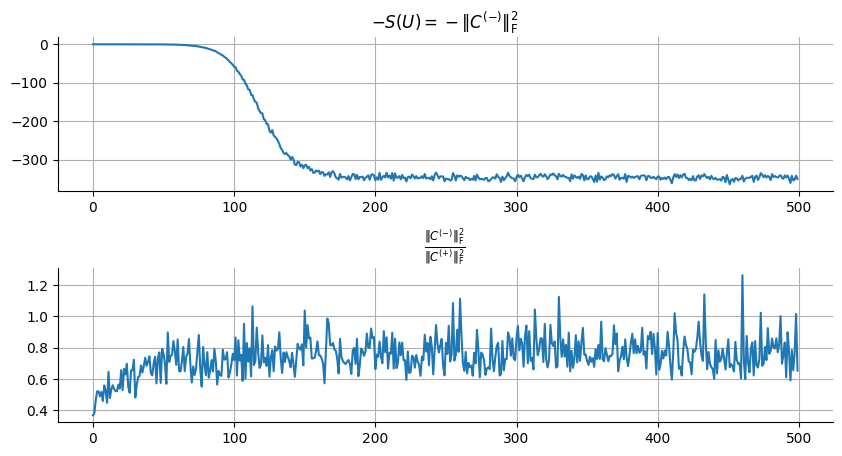

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

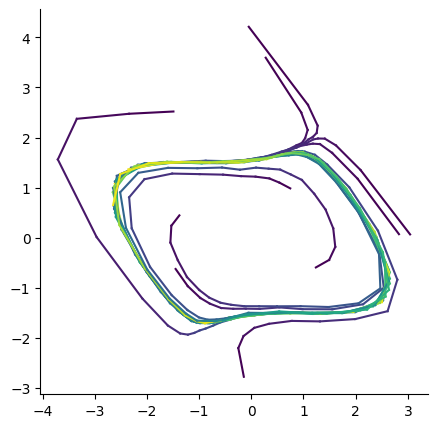

In [19]:
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)
projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


plot_2D(projection)
#plt.title(f"sca {var_explained(K_A_X, optimized_alpha_H):.2f}")